In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(19758, 28)
(19758, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149, 0.0, 0.0, -0.0575137704686, 0.0700262483306,
       -0.0177582072335, 0.00282305354852, 0.00383982704313,
       0.0149367574186, -0.394622782974, 0.0470562756282,
       0.000190880443402, -0.0143910438763, 0.410776979039,
       -0.000293245359969, -0.0140386821078, -0.392070472035,
       0.000263396218383, 0.407262437373, -0.0250143312816,
       -0.000161031301815, True, False, False, True, 0.10000000149, 0.0,
       0.0], dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.024368676025119385, -0.007677743332976661], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(9875, 28)
(9875, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.10000000149, 0.0, 0.0, -0.0676389664824, -0.0528462910872,
       -0.00750896044119, 0.00137157174964, -0.0041430543334,
       -0.0159415557872, -0.0773945234722, -0.406116918459,
       0.000304750451427, -0.386529745697, 0.0203541753833,
       -0.000454600231953, 0.414702722255, -0.0255079577864,
       0.000265283941099, 0.0406443912005, 0.390287455385,
       -0.000115434160573, False, True, True, False, 0.10000000149, 0.0,
       0.0], dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.018461610297009656, 0.005742571233412264], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9579449669715936
RMSE:  0.008022187727483879
The lowest error is:  2.4457593916643594e-06
The highest error is:  0.09029345530814731
The avg. error is:  0.005026027934648249


In [13]:
model_fr_com_x.coef_

array([[-0.01774458, -0.00381839,  0.00216132,  0.14465831, -0.0123897 ,
         0.00338333, -0.06881803,  0.00574232,  0.04454857,  0.03849949,
         0.0760274 ,  0.00329115,  0.06250181,  0.14490249, -0.19495986,
        -0.00050792, -0.05530554,  0.05952474,  0.09935826,  0.00498852]])

In [14]:
model_fr_com_x.intercept_

array([0.00548805])

In [15]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 14)

Text(0, 0.5, 'Predictions')

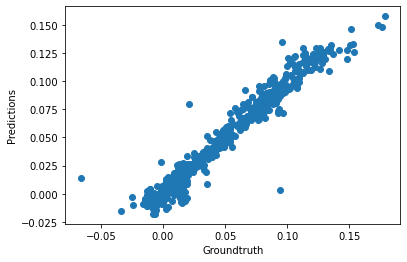

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#%store model_fr_com_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [19]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 3:9],
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.870959693344687
RMSE:  0.00893083545995224
The lowest error is:  4.936164579368019e-06
The highest error is:  0.13447273080559818
The avg. error is:  0.005759732020641405


In [20]:
model_fr_com_y.coef_

array([[-1.10390599e-02, -1.65410805e-02, -2.25919487e-02,
        -1.04646794e-02,  1.56125618e-01, -2.06100955e-04,
        -5.82257757e-03, -1.21729487e-02,  2.83739375e-02,
         9.84605532e-03, -1.47903315e-02,  4.70618603e-02,
        -1.43218841e-01, -2.61599871e-01, -3.57017707e-02,
        -2.27715697e-01, -9.83038558e-02, -1.64137873e-01,
        -7.23190737e-02, -2.16732930e-01]])

In [22]:
model_fr_com_y.intercept_

array([0.00371011])

Text(0, 0.5, 'Predictions')

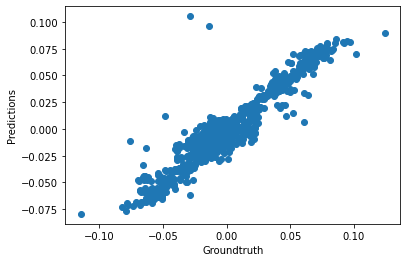

In [21]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fr_com_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")